In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Use GPU if available

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
   
The output of [torchvision datasets](https://pytorch.org/vision/stable/datasets.html#datasets) are PILImage images of range [0, 1].
We [transform](https://pytorch.org/vision/stable/transforms.html) them to normalized Tensors. Then we call the [dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)



In [3]:
# Define data transformation pipeline
transform = transforms.Compose([
    # Convert PIL images to PyTorch tensors
    transforms.ToTensor(),
    # Normalize pixel values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Create data loader for training data with batch size 4 and shuffling
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Load the CIFAR-10 testing dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Create data loader for testing data with batch size 1 and shuffling
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=True, num_workers=2)

# Define class labels for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:18<00:00, 9188298.72it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us [show](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib-pyplot-imshow) some of the training images


Train loader:
12500
{'frog': 5000, 'truck': 5000, 'deer': 5000, 'car': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'plane': 5000}
torch.Size([4, 3, 32, 32])
ship plane cat frog

Test loader:
10000
{'cat': 1000, 'ship': 1000, 'plane': 1000, 'frog': 1000, 'car': 1000, 'truck': 1000, 'dog': 1000, 'horse': 1000, 'deer': 1000, 'bird': 1000}


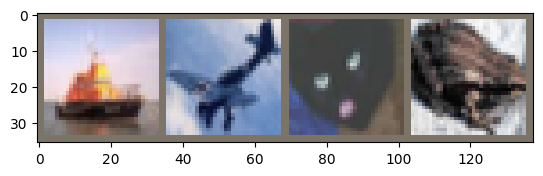

In [4]:
import matplotlib.pyplot as plt  # Import library for plotting
import numpy as np  # Import library for numerical computations
from collections import Counter  # Import Counter for counting elements

# Function to display an image
def imshow(image):
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])

    # Unnormalize the image channels to [0, 1]
    image = image.mul(std.unsqueeze(1).unsqueeze(2))  # More efficient element-wise multiplication
    image = image.add(mean.unsqueeze(1).unsqueeze(2))  # Efficient element-wise addition

    image= image.clamp(0, 1)

    # Convert the tensor to a NumPy array
    npimg = image.numpy()
    # Plot the image using matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose for correct display

# ------------------ Train Loader Section ------------------

print("Train loader:")

# Count the frequency of each class in the training set
stat = dict(Counter(trainset.targets))

# Create a new dictionary with class names as keys
new_stat = stat.copy()
for k in stat.keys():
    new_stat[classes[k]] = stat[k]
    del new_stat[k]

# Print the length of the train loader (number of batches)
print(len(trainloader))

# Print the class distribution in the training set
print(new_stat)

# Get a batch of random training images and their labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Print the shape of the image tensor (batch_size, channels, height, width)
print(images.shape)

# Display the images using the imshow function
imshow(torchvision.utils.make_grid(images))

# Print the labels of the images
print(' '.join('%s' % classes[labels[j]] for j in range(4)))  # Print labels for 4 images

# ------------------ Test Loader Section ------------------

print("\nTest loader:")

# Similar steps for the test loader
stat = dict(Counter(testset.targets))
new_stat = stat.copy()
for k in stat.keys():
    new_stat[classes[k]] = stat[k]
    del new_stat[k]

print(len(testloader))
print(new_stat)


2. Define a Convolution Neural Network.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, nClasses=10):
        super(Net, self).__init__()  # Call the superclass constructor
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Second convolutional layer
        self.pool =  nn.MaxPool2d(2, 2) # output: 64 x 16 x 16

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # Third convolutional layer
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)  # Fourth convolutional layer
        # output: 128 x 8 x 8

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)    # Fifth convolutional layer
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)    # Sixth convolutional layer
        # output: 256 x 4 x 4

        self.fc1 = nn.Linear(256*4*4, 1024)  # First fully-connected layer
        self.fc2 = nn.Linear(1024, 512)  # Second fully-connected layer
        self.fc3 = nn.Linear(512, nClasses) # Output layer


    def forward(self, x):

        x = F.rrelu(self.conv1(x))  # First convolutional layer with RReLU activation
        x = self.pool(F.rrelu(self.conv2(x))) # Second convolutional layer with RReLU activation and pooling

        x = F.rrelu(self.conv3(x))  # Third convolutional layer with RReLU activation
        x = self.pool(F.rrelu(self.conv4(x))) # Fourth convolutional layer with RReLU activation and pooling

        x = F.rrelu(self.conv5(x))  # Fifth convolutional layer with RReLU activation
        x = self.pool(F.rrelu(self.conv6(x))) # Sixth convolutional layer with RReLU activation and pooling

        x = x.view(x.shape[0],-1)  # Flatten the output from convolutional layers

        x = F.rrelu(self.fc1(x))  # First fully-connected layer with RReLU activation
        x = F.rrelu(self.fc2(x))  # Second fully-connected layer with RReLU activation
        x = self.fc3(x)  # Output layer
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)

Compute the receptive field of the network

In [6]:
# This line attempts to clone a Git repository using a shell command.
!git clone https://github.com/Fangyh09/pytorch-receptive-field.git

# This line would move the downloaded directory
!mv -v pytorch-receptive-field/torch_receptive_field ./

# Import the 'receptive_field' function from the 'torch_receptive_field' library.
from torch_receptive_field import receptive_field

# Calculate the receptive field of the network 'net' for an input image size of
# 3 channels (RGB) and 32x32 pixels. The 'receptive_field' function would analyze the network architecture and input size to determine
# the receptive field size for each layer and the overall network.
receptive_field(net, input_size=(3, 32, 32))


Cloning into 'pytorch-receptive-field'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 183 (delta 70), reused 31 (delta 26), pack-reused 67 (from 1)
Receiving objects: 100% (183/183), 1.81 MiB | 33.79 MiB/s, done.
Resolving deltas: 100% (84/84), done.
renamed 'pytorch-receptive-field/torch_receptive_field' -> './torch_receptive_field'
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0               [32, 32]        0.5        1.0             1.0 
        1               [32, 32]        0.5        1.0             3.0 
        2               [32, 32]        0.5        1.0             5.0 
        3               [16, 16]        1.0        2.0             6.0 
        4               [16, 16]        1.0        2.0            10.0 
        5               [16, 16]        1.0   

OrderedDict([('0',
              OrderedDict([('j', 1.0),
                           ('r', 1.0),
                           ('start', 0.5),
                           ('conv_stage', True),
                           ('output_shape', [-1, 3, 32, 32])])),
             ('1',
              OrderedDict([('j', 1.0),
                           ('r', 3.0),
                           ('start', 0.5),
                           ('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 32, 32, 32])])),
             ('2',
              OrderedDict([('j', 1.0),
                           ('r', 5.0),
                           ('start', 0.5),
                           ('input_shape', [-1, 32, 32, 32]),
                           ('output_shape', [-1, 64, 32, 32])])),
             ('3',
              OrderedDict([('j', 2.0),
                           ('r', 6.0),
                           ('start', 1.0),
                           ('input_shape', [-1, 64, 32, 32]),
         

In [7]:
# Summary of the network
from torchsummary import summary
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
            Conv2d-5          [-1, 128, 16, 16]         147,584
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
            Conv2d-8            [-1, 256, 8, 8]         590,080
         MaxPool2d-9            [-1, 256, 4, 4]               0
           Linear-10                 [-1, 1024]       4,195,328
           Linear-11                  [-1, 512]         524,800
           Linear-12                   [-1, 10]           5,130
Total params: 5,851,338
Trainable params: 5,851,338
Non-trainable params: 0
---------------------------

3. Define a loss function and optimizer

Let's use a Classification [Cross-Entropy](https://pytorch.org/docs/stable/nn.html#loss-functions) loss and [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) with momentum.



In [8]:
import torch.optim as optim  # Import the optim module from PyTorch for optimization algorithms

# Define the loss function
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for multi-class classification

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001 )



4. Train the network on the training data


We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [9]:
num_print_intervals = 4  # Number of times to print statistics
epochs = 10    # Number of training epochs

num_print_intervals+=1
print_interval = int(len(trainloader) / num_print_intervals)

# Initialize a list to save the loss and the accuracy for each epoch
epoch_losses = []
epoch_accuracies = []

# Loop over the dataset multiple times
for epoch in range(epochs):
    running_loss=[]  # Initialize a variable to track the total loss for this epoch
    correct = 0
    tot = 0

    # Iterate over the training data loader
    for i, data in enumerate(trainloader, 0):
        # Get the inputs (images) and labels from the current batch
        inputs, labels = data

        # Move the inputs and labels to the specified device (CPU or GPU)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clear the gradients accumulated in the previous iteration
        optimizer.zero_grad()

        # Training loop: forward pass, backward pass, and optimization
        # 1. Forward pass:
        outputs = net(inputs)  # Pass the input images through the network to get predictions (outputs)
        # 2. Calculate loss:
        loss = criterion(outputs, labels)  # Compute the loss based on the predictions (outputs) and ground truth labels
        # 3. Backward pass:
        loss.backward()  # Backpropagate the loss to calculate gradients for each parameter in the network
        # 4. Optimization step:
        optimizer.step()  # Update the weights and biases of the network based on the calculated gradients

        running_loss.append(loss.item())  # Accumulate the loss for this mini-batch

        # Make predictions to calculate accuracy
        _, pred = torch.max(outputs.data, 1)
        tot += labels.size(0)
        correct += (pred == labels).sum().item()

        if i>0 and i % print_interval == 0:  # Check batch interval
            # Print the average loss for the mini-batches
            print('[%d, %5d] loss: %.4f' %
                  (epoch + 1, i + 1, np.mean(running_loss)))
            # Reset the running loss for the next interval
            running_loss=[]

    # Save the average loss for the epoch
    epoch_losses.append(np.mean(running_loss))

    # Compute and save the accuracy for the epoch
    accuracy = 100 * correct / tot
    epoch_accuracies.append(accuracy)

# Training complete
print('Finished Training')


[1,  2501] loss: 1.7281
[1,  5001] loss: 1.3300
[1,  7501] loss: 1.1530
[1, 10001] loss: 1.0066
[2,  2501] loss: 0.8007
[2,  5001] loss: 0.7678
[2,  7501] loss: 0.7128
[2, 10001] loss: 0.6990
[3,  2501] loss: 0.5592
[3,  5001] loss: 0.5514
[3,  7501] loss: 0.5465
[3, 10001] loss: 0.5271
[4,  2501] loss: 0.3914
[4,  5001] loss: 0.4053
[4,  7501] loss: 0.4246
[4, 10001] loss: 0.4214
[5,  2501] loss: 0.2908
[5,  5001] loss: 0.3004
[5,  7501] loss: 0.3024
[5, 10001] loss: 0.3137
[6,  2501] loss: 0.2023
[6,  5001] loss: 0.2282
[6,  7501] loss: 0.2398
[6, 10001] loss: 0.2427
[7,  2501] loss: 0.1593
[7,  5001] loss: 0.1706
[7,  7501] loss: 0.1919
[7, 10001] loss: 0.1936
[8,  2501] loss: 0.1139
[8,  5001] loss: 0.1453
[8,  7501] loss: 0.1541
[8, 10001] loss: 0.1641
[9,  2501] loss: 0.1134
[9,  5001] loss: 0.1187
[9,  7501] loss: 0.1272
[9, 10001] loss: 0.1377
[10,  2501] loss: 0.0937
[10,  5001] loss: 0.1064
[10,  7501] loss: 0.1139
[10, 10001] loss: 0.1283
Finished Training


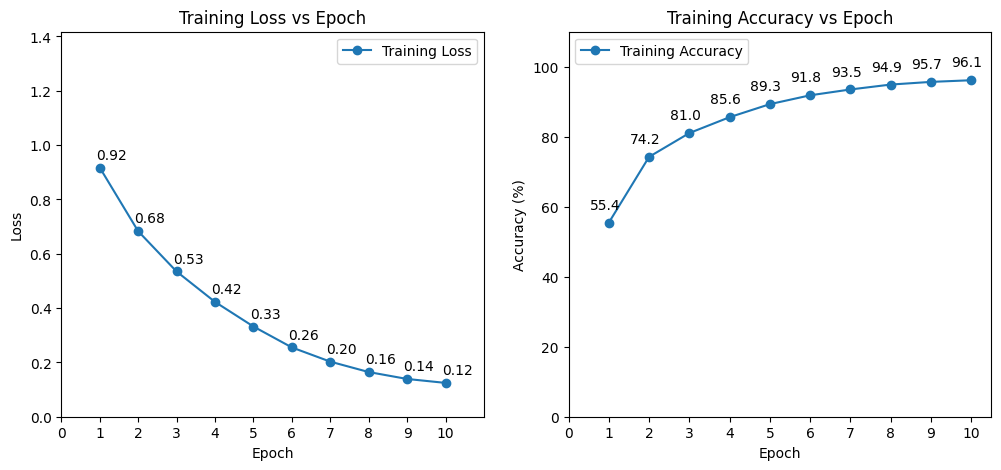

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss VS Epoch
axs[0].plot(range(1, len(epoch_losses) + 1), epoch_losses,'-o', label='Training Loss')
axs[0].set(xlabel='Epoch', ylabel='Loss', title='Training Loss vs Epoch', xlim=[0.5, len(epoch_losses) + 1], ylim=[0, max(epoch_losses) + 0.5], xticks=np.arange(11))

for i, loss in enumerate(epoch_losses):
    axs[0].text(i+1.3, loss + 0.02, f'{loss:.2f}', ha='center', va='bottom')

axs[0].legend()

# Plot Accuracy VS Epoch
axs[1].plot(range(1, len(epoch_accuracies) + 1), epoch_accuracies,'-o', label='Training Accuracy')
axs[1].set(xlabel='Epoch', ylabel='Accuracy (%)', title='Training Accuracy vs Epoch', xlim=[0, len(epoch_accuracies) + 0.5], ylim=[0, 110], xticks=np.arange(11))

for i, acc in enumerate(epoch_accuracies):
    axs[1].text(i+0.9, acc + 3, f'{acc:.1f}', ha='center', va='bottom')

axs[1].legend(loc='upper left')

plt.savefig("tr_loss_acc.png")
plt.show()

5. Test the network on the test data


Predict the class label that the neural network
outputs, and check it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

In [11]:
# Initialize variables to track accuracy and missclassifications
nClasses = 10
class_correct = [0] * nClasses
class_total = [0] * nClasses
total_correct = 0
total_images = 0
true_labels = []
predicted_labels = []
misclassified_indices = []

# Disable gradient calculation for better performance during evaluation
with torch.no_grad():
    # Loop over the test loader
    for batch_idx, data in enumerate(testloader):
        # Get the image and label from the current batch
        images, labels = data

        # Move the image data to the specified device (CPU or GPU)
        images = images.to(device)

        # Get the network's prediction for the image
        output = net(images)
        # smax = torch.nn.Softmax(dim=1)(output.cpu())

        # Find the class with the highest probability
        _, predicted = torch.max(output.cpu(), 1)  # Equivalent to pred = torch.argmax(output.cpu(), dim=1)

        # Store true labels and predicted labels
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

        # Update total number of test images
        total_images += labels.size(0)  # label.size(0) gives the batch size

        # Count correct predictions
        correct = (predicted == labels)

        for i in range(labels.size(0)):
            label = labels[i].item()
            #print(label)
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            if not correct[i]:
                misclassified_indices.append(batch_idx * testloader.batch_size + i)

# Calculate and print accuracy class by class
for i in range(nClasses):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    total_correct += class_correct[i]

# Calculate and print total accuracy
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * total_correct / total_images))


Accuracy of plane : 81 %
Accuracy of   car : 92 %
Accuracy of  bird : 77 %
Accuracy of   cat : 61 %
Accuracy of  deer : 84 %
Accuracy of   dog : 70 %
Accuracy of  frog : 88 %
Accuracy of horse : 85 %
Accuracy of  ship : 91 %
Accuracy of truck : 84 %
Accuracy of the network on the 10000 test images: 81 %


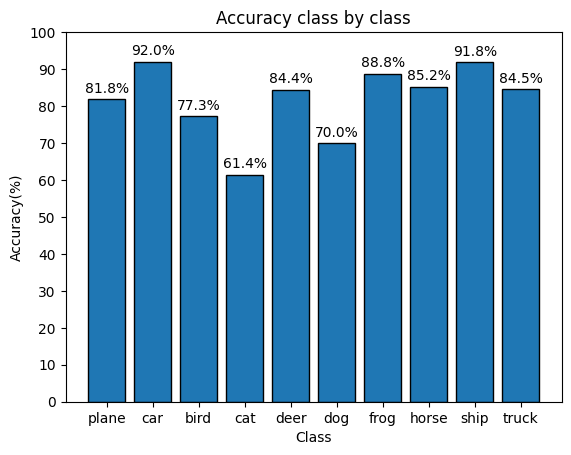

In [12]:
# Plot the accuracies bars
accs = 100 * np.array(class_correct) / np.array(class_total)

plt.bar(x=np.arange(len(classes)),height=accs, tick_label=classes, edgecolor='black')
plt.xlabel("Class")
plt.ylabel("Accuracy(%)")
plt.title("Accuracy class by class")
plt.yticks(np.arange(0, 101, 10))

# Add accuracy values on top of the bars
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', va='bottom')
plt.savefig("acc_bars.png")
plt.show()

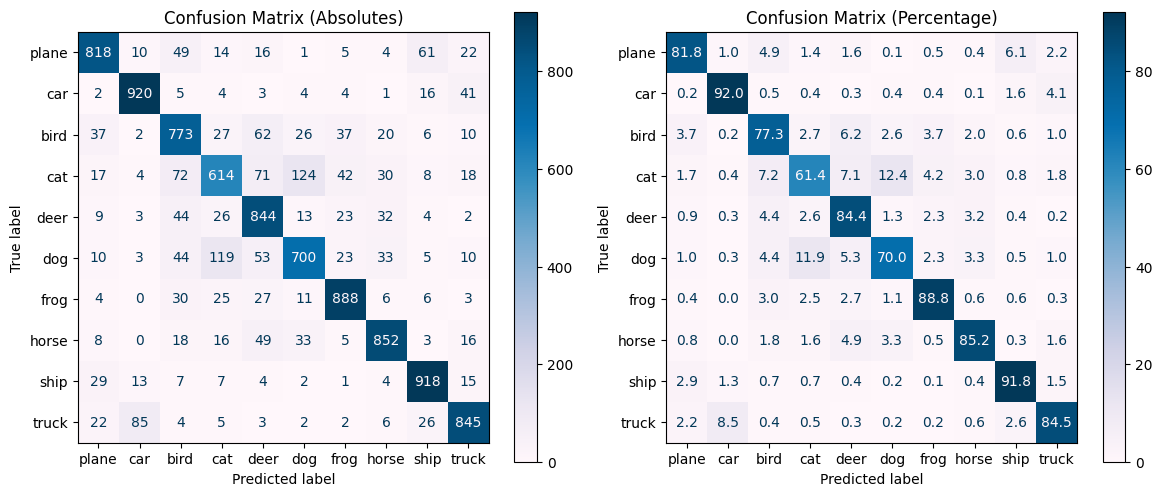

In [13]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots

color_map = "PuBu"

# Plot confusion matrix with absolute values
axs[0].set_title('Confusion Matrix (Absolutes)')
CM_absolute = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(true_labels, predicted_labels),
    display_labels=classes
    )
CM_absolute.plot(cmap=color_map, ax=axs[0])

# Plot confusion matrix with percentages
axs[1].set_title('Confusion Matrix (Percentage)')
conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_percentage = np.round(conf_matrix_percentage * 100, decimals=1)
CM_percentage = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix_percentage,
    display_labels=classes
    )
CM_percentage.plot(cmap=color_map, ax=axs[1], values_format=".1f")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig("confmatr.png")
plt.show()

In [14]:
# Define a function to plot misclassified images
# The predicted class is specified with pred_idx, the true label with gt_idx
import random
def plot_misclassified(pred_idx, gt_idx, nImgs):
  currImg = 0

  fig, axs = plt.subplots(1, nImgs, figsize=(12, 5))

  mean=torch.tensor([0.485, 0.456, 0.406])
  std=torch.tensor([0.229, 0.224, 0.225])

  indeces = []
  # Get the indeces of the missclassified sample (of the 2 chosen classes)
  for idx in misclassified_indices:
      image, label = testset[idx]
      if predicted_labels[idx]==pred_idx and label==gt_idx:
        indeces.append(idx)

  for i in range(nImgs):
      idx = random.choice(indeces)  # randomly choose one of the collected indeces
      image, label = testset[idx]
      indeces.remove(idx)  # remove the current index from the list so that the same image won't be plotted twice

      image = image.mul(std.unsqueeze(1).unsqueeze(2))
      image = image.add(mean.unsqueeze(1).unsqueeze(2))

      image= image.clamp(0, 1)
      currImg+=1
      # Plot the image
      plt.subplot(1, nImgs, currImg)
      plt.imshow(image.permute(1, 2, 0))
      plt.axis('off')

  plt.suptitle(f"True: {classes[gt_idx]}, Predicted: {classes[pred_idx]}", y=0.8)
  plt.tight_layout()
  plt.show()

By looking at the Confusion Matrix we see that the highest percentages of misclassifications involve dogs and cats, planes and ships, cars and trucks, planes and birds, thus we can visualize some of these misclassified images.

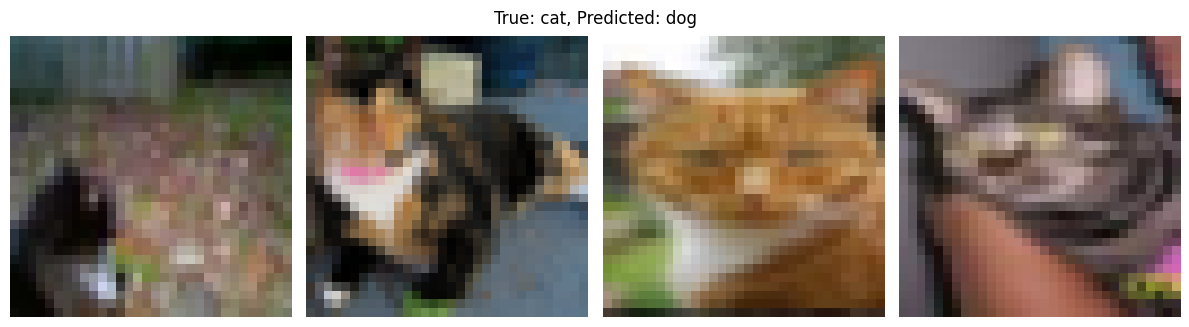

In [15]:
# Dogs and Cats
plot_misclassified(5,3,4)

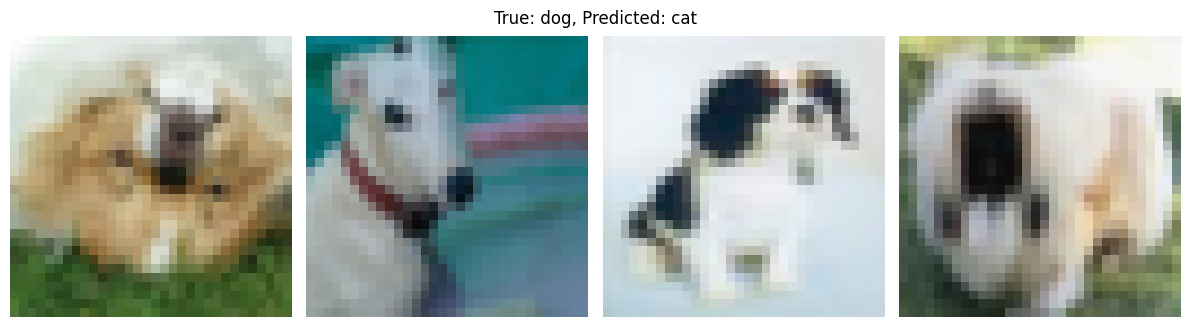

In [16]:
# Cats and Dogs
plot_misclassified(3,5,4)

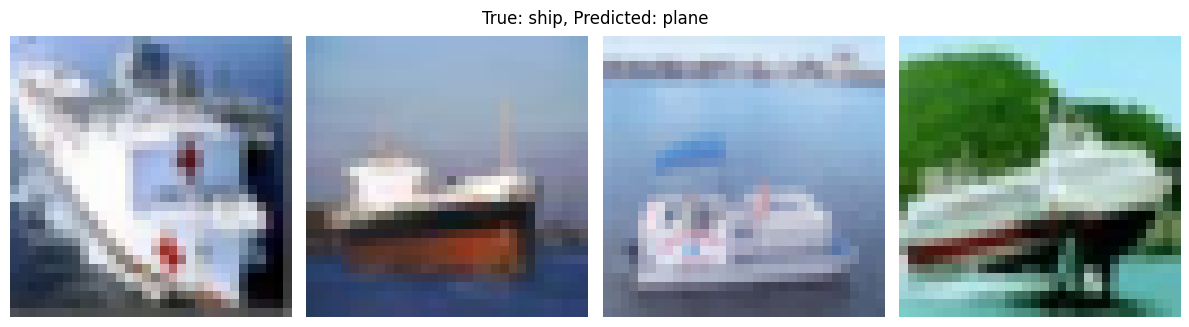

In [17]:
# Planes and Ships
plot_misclassified(0,8,4)

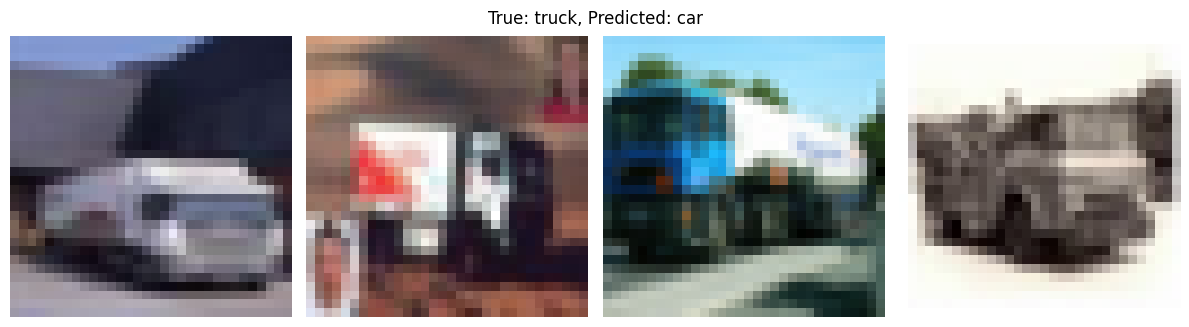

In [18]:
# Cars and Trucks
plot_misclassified(1,9,4)

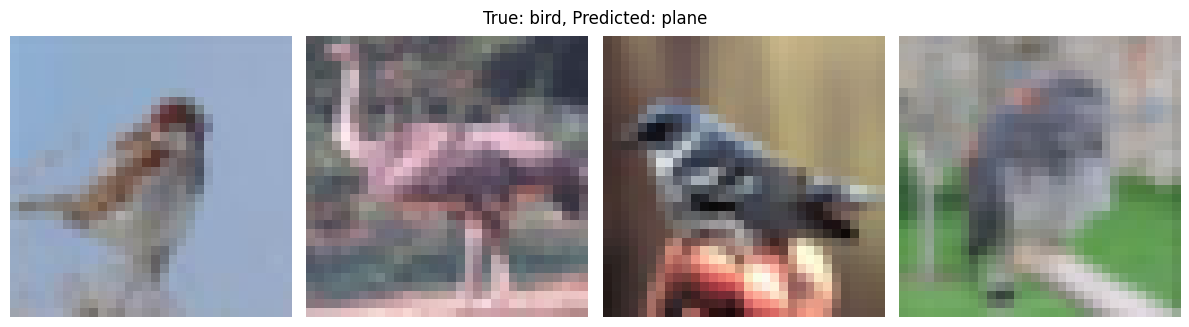

In [19]:
# Planes and Birds
plot_misclassified(0,2,4)